# Assignment 4: recurrent neural networks

In this assignment, you'll create a model with LSTM or GRU to predict the indices of S&P 500

## Dataset and Objectives

A time series containing the indices of S&P 500 from 2010 to 2017 can be found at <a href = "https://archive.ics.uci.edu/ml/datasets/CNNpred%3A+CNN-based+stock+market+prediction+using+a+diverse+set+of+variables"> UCI Machine Data Repository</a>. A detailed description of the dataset can be found <a href = "https://www.researchgate.net/profile/Ehsan-Hoseinzade/publication/331911968_CNNpred_CNN-based_stock_market_prediction_using_a_diverse_set_of_variables/links/5cb07442299bf120975fd0fd/CNNpred-CNN-based-stock-market-prediction-using-a-diverse-set-of-variables.pdf">here (see pages 31-32)</a>. A snippet of the data is shown below. 

You're required to build a model to predict the daily `close` indices. From the plot, you can find that the indices fluctuate from day to day.

The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (e.g. 5 days, a timestep is 1 day), we would like to make two predictions:
- **Regression**: the `Close` indices of next day
- **Binary Classification**: whether the `Close` indices of next day is higher than the current day (i.e. `Buy or Hold`)

There are a number of useful features in the dataset, e.g. `change of volume`, `moving average` etc. For demonstration, I just show a few of them below.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("Processed_S&P.csv", parse_dates=[0])
data = data[["Date", "Close", "Volume", \
             "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]]

# drop records with missing values
data = data.dropna(axis = 0)
print("Start date: ", data["Date"].min())
print("End date: ", data["Date"].max())

data = data.sort_values(by = "Date")

data.head()

Start date:  2010-03-15 00:00:00
End date:  2017-11-15 00:00:00


,Date,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50
49,2010-03-15,1150.510010,-0.155038,0.000452,-0.000217,0.004042,0.004525,1.054898,3.119095,3.835705,6.973436,1137.793700,1125.859965,1112.939394
50,2010-03-16,1159.459961,0.049389,0.007779,0.000452,-0.000217,0.004042,1.666887,3.679651,5.925451,5.899327,1141.733020,1129.059965,1114.763730
51,2010-03-17,1166.209961,0.135803,0.005822,0.007779,0.000452,-0.000217,1.798167,4.238501,5.516446,6.066334,1146.183373,1132.598059,1116.781230
52,2010-03-18,1165.829956,-0.146819,-0.000326,0.005822,0.007779,0.000452,1.355366,3.816664,5.702034,5.338148,1149.755479,1135.763002,1118.704709
53,2010-03-19,1159.900024,0.230936,-0.005086,-0.000326,0.005822,0.007779,0.861750,1.861779,5.016798,4.573688,1151.599942,1138.061766,1120.320212


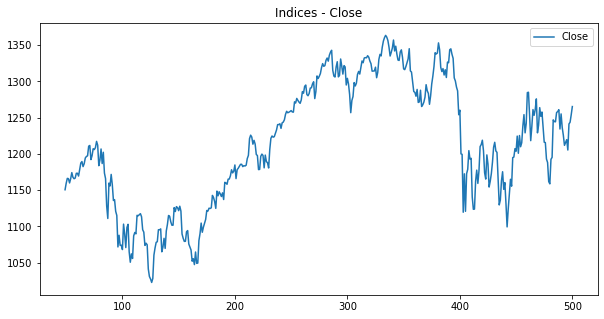

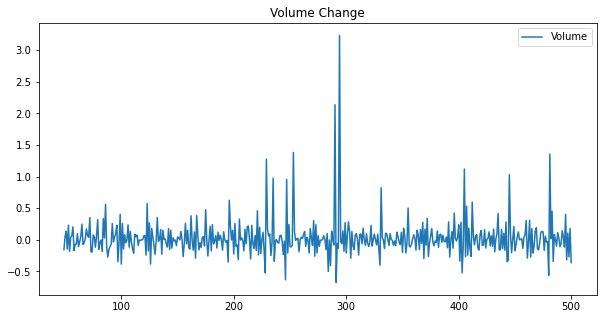

In [402]:
from matplotlib import pyplot as plt
data.loc[0:500]["Close"].plot(kind="line", figsize=(10,5), title = "Indices - Close")
plt.legend()
plt.show()

data.loc[0:500]["Volume"].plot(kind="line", figsize=(10,5), title = "Volume Change")
plt.legend()
plt.show()

## Task 1: Preparing the data

* Preprocess the data to a format a neural network can ingest. Write a function called `generate_data` to generate input and target values as follows:

    - Set `2016-05-06` as a cut-off date and use all observations after this date for testing purpose (20% of the observations) and the remaining for training (including validation).  
    
    - Transform the dataset by `z-normalization`. Since the features are in different scales, it is necessary to normalize them. A typical technique is z-normalization, $x^{'} = (x - \mu)/\sigma$ where $\mu$ is the mean and $\sigma$ is the standard deviation. However, don't rely on batch normalization technique here, since a random batch cannot preserve the trending of the time series. Instead, for this step, do the following:
        - Fit a scaler using `only the training subset` (i.e calculate $\mu$ and $\sigma$). Your testing subset should `never` be exposed to the scaler or your training program. You can use package <a href ="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html"> `sklearn.preprocessing.StandardScaler`</a> for this step.
        - Transform the entire dataset using the fitted scaler. If you want to transform the data back to the orginal, you can call the scaler's `inverse_transform` function. 

    - Slice the transformed dataset in every `lookback` days. For example, let ($x_i, y_i$) denote the $i$th sample. $x_i$ `= X[i : (i + lookback)]` and $y_i$ `= Y[ i + lookback]`, where X is the transformed values of the dataframe, `feature_cols` are the columns you use as features, and Y is the transformed `Close` column (or the binary target). You can use any column as a feature, or engineer new features.   
    
    - Return transformed features, targets (for both regression and binary classification) and scaler.
    
    

* Finally, set aside the portion of transformed observations after the cut-off date as the `testing` subset. Then for the remaining ones, hold out 20% for `validation` and the rest for model `training`.

In [2]:
# split data into train set & test set

cut_off_date ='2016-05-06'

train_data = data[data['Date']<=cut_off_date].drop(['Date'],axis=1)     # no date
test_data = data[data['Date']>cut_off_date].drop(['Date'],axis=1)      # no date

print(train_data.shape)
print(test_data.shape)

(1549, 13)
(386, 13)


In [3]:
data = data.drop(['Date'],axis=1)           # no date
print(data.shape)

(1935, 13)


In [4]:
# scale data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data)                             # fit
data_scaled = scaler.transform(data).round(3)      # transform

data_scaled[:3,:5]                                  # show 3 rows    # numpy array

array([[-1.328, -0.796,  0.003, -0.064,  0.36 ],
       [-1.302,  0.138,  0.732,  0.003, -0.064],
       [-1.282,  0.533,  0.537,  0.733,  0.003]])

In [5]:
data_scaled_df = pd.DataFrame(data_scaled, \
                              columns=['Close','Volume','mom','mom1','mom2','mom3','ROC_5','ROC_10','ROC_15','ROC_20',\
                                       'EMA_10','EMA_20','EMA_50'] )     # shape (1935, 13)

In [6]:
 # add Y_bi column, 0 or 1

data_scaled_df['Y_bi']=0                   
for i in range(len(data_scaled_df)-1):
    if data_scaled_df.at[i+1, 'Close'] > data_scaled_df.at[i, 'Close']:
        data_scaled_df.at[i, 'Y_bi']=1

data_scaled_df.head(10)

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,Y_bi
0,-1.328,-0.796,0.003,-0.064,0.360,0.407,0.396,0.976,0.960,1.633,-1.359,-1.387,-1.401,1
1,-1.302,0.138,0.732,0.003,-0.064,0.359,0.684,1.179,1.591,1.345,-1.348,-1.378,-1.396,1
2,-1.282,0.533,0.537,0.733,0.003,-0.065,0.746,1.381,1.468,1.390,-1.335,-1.367,-1.390,0
3,-1.283,-0.758,-0.075,0.538,0.732,0.002,0.538,1.228,1.524,1.195,-1.325,-1.358,-1.385,0
4,-1.300,0.968,-0.549,-0.075,0.537,0.732,0.305,0.520,1.317,0.990,-1.319,-1.351,-1.380,1
5,-1.283,-0.921,0.465,-0.549,-0.075,0.537,0.526,0.714,1.158,1.162,-1.312,-1.344,-1.375,1
6,-1.259,0.073,0.672,0.465,-0.549,-0.076,0.497,0.917,1.310,1.712,-1.301,-1.335,-1.369,0
7,-1.278,0.217,-0.590,0.672,0.465,-0.550,-0.039,0.544,1.123,1.279,-1.296,-1.328,-1.364,0
8,-1.284,0.848,-0.212,-0.589,0.672,0.464,-0.104,0.333,0.952,1.290,-1.293,-1.322,-1.359,1
9,-1.281,-0.862,0.031,-0.212,-0.590,0.671,0.171,0.368,0.542,1.271,-1.290,-1.317,-1.355,1


In [7]:
 # add Y_bi column, 0 or 1

data_scaled_df['Y_bi']=0                   
for i in range(len(data_scaled_df)-1):
    if data_scaled_df.at[i+1, 'Close'] > data_scaled_df.at[i, 'Close']:
        data_scaled_df.at[i, 'Y_bi']=1

data_scaled_df.head(10)

,Close,Volume,mom,mom1,mom2,mom3,ROC_5,ROC_10,ROC_15,ROC_20,EMA_10,EMA_20,EMA_50,Y_bi
0,-1.328,-0.796,0.003,-0.064,0.360,0.407,0.396,0.976,0.960,1.633,-1.359,-1.387,-1.401,1
1,-1.302,0.138,0.732,0.003,-0.064,0.359,0.684,1.179,1.591,1.345,-1.348,-1.378,-1.396,1
2,-1.282,0.533,0.537,0.733,0.003,-0.065,0.746,1.381,1.468,1.390,-1.335,-1.367,-1.390,0
3,-1.283,-0.758,-0.075,0.538,0.732,0.002,0.538,1.228,1.524,1.195,-1.325,-1.358,-1.385,0
4,-1.300,0.968,-0.549,-0.075,0.537,0.732,0.305,0.520,1.317,0.990,-1.319,-1.351,-1.380,1
5,-1.283,-0.921,0.465,-0.549,-0.075,0.537,0.526,0.714,1.158,1.162,-1.312,-1.344,-1.375,1
6,-1.259,0.073,0.672,0.465,-0.549,-0.076,0.497,0.917,1.310,1.712,-1.301,-1.335,-1.369,0
7,-1.278,0.217,-0.590,0.672,0.465,-0.550,-0.039,0.544,1.123,1.279,-1.296,-1.328,-1.364,0
8,-1.284,0.848,-0.212,-0.589,0.672,0.464,-0.104,0.333,0.952,1.290,-1.293,-1.322,-1.359,1
9,-1.281,-0.862,0.031,-0.212,-0.590,0.671,0.171,0.368,0.542,1.271,-1.290,-1.317,-1.355,1


In [9]:
# define X, Y, Y_bi

feature_cols = ['Close', 'Volume', 'mom', 'mom3', 'ROC_5', 'ROC_20', 'EMA_10', 'EMA_20']
target_col = ['Close']

X_scaled = data_scaled_df[feature_cols]
Y_scaled = data_scaled_df[target_col]
Y_bi = data_scaled_df[['Y_bi']]

print(X_scaled.shape)
print(Y_scaled.shape)
print(Y_bi.shape)

(1935, 8)
(1935, 1)
(1935, 1)


In [10]:
# Slice the transformed dataset in every lookback days

lookback = 5
lookback_value_list = []

for i in range(len(X_scaled)):     # each row
    item = X_scaled[i:(i+lookback)]      # 5 rows
    lookback_value_list.append(item)   # group 5 rows
    
lookback_value_list = lookback_value_list[:-4]    # drop last 4 items
X_scaled = np.stack(lookback_value_list, axis=0)             
Y_scaled = Y_scaled.shift(periods=-5)[:len(X_scaled)]                       
Y_bi = Y_bi.shift(periods=-1)[:len(X_scaled)]         
# Y_scaled = Y_scaled[:len(X_scaled)]                       
# Y_bi = Y_bi[:len(X_scaled)] 

print(X_scaled.shape)
print(Y_scaled.shape)
print(Y_bi.shape)

(1931, 5, 8)
(1931, 1)
(1931, 1)


In [11]:
print("Show a few observations:")
print("Before transformation:")
print(data.iloc[0:7,0:3])
print("\nAfter transformation:")
print("X:")
print(X_scaled[0:2,:,0:3])
print("\nY - Regression:")
print(Y_scaled[0:2])
print("Y - Classification:")
print(Y_bi[0:2])

Show a few observations:
Before transformation:
          Close    Volume       mom
49  1150.510010 -0.155038  0.000452
50  1159.459961  0.049389  0.007779
51  1166.209961  0.135803  0.005822
52  1165.829956 -0.146819 -0.000326
53  1159.900024  0.230936 -0.005086
54  1165.810059 -0.182397  0.005095
55  1174.170044  0.035188  0.007171

After transformation:
X:
[[[-1.328 -0.796  0.003]
  [-1.302  0.138  0.732]
  [-1.282  0.533  0.537]
  [-1.283 -0.758 -0.075]
  [-1.3    0.968 -0.549]]

 [[-1.302  0.138  0.732]
  [-1.282  0.533  0.537]
  [-1.283 -0.758 -0.075]
  [-1.3    0.968 -0.549]
  [-1.283 -0.921  0.465]]]

Y - Regression:
   Close
0 -1.283
1 -1.259
Y - Classification:
   Y_bi
0   1.0
1   0.0


In [12]:
# Split transformed data into training, validation and testing subsets

from sklearn.model_selection import train_test_split

test_Y = Y_scaled[(-len(test_data)):]
test_Y_bi = Y_bi[(-len(test_data)):]
test_X = X_scaled[(-len(test_data)):]

train_X, val_X, train_Y, val_Y, train_Y_bi, val_Y_bi = train_test_split(\
                                                                        X_scaled[:len(train_data)], \
                                                                        Y_scaled[:len(train_data)],\
                                                                        Y_bi[:len(train_data)],\
                                                                        test_size=0.2, shuffle=True)

print('Train X, Y, Y_binary shapes: \n', train_X.shape, train_Y.shape, train_Y_bi.shape)
print('Validation X, Y, Y_binary shapes: \n', val_X.shape, val_Y.shape, val_Y_bi.shape)
print('Test X, Y, Y_binary shapes: \n', test_X.shape, test_Y.shape, test_Y_bi.shape)

Train X, Y, Y_binary shapes: 
 (1239, 5, 8) (1239, 1) (1239, 1)
Validation X, Y, Y_binary shapes: 
 (310, 5, 8) (310, 1) (310, 1)
Test X, Y, Y_binary shapes: 
 (386, 5, 8) (386, 1) (386, 1)


## Task 2: Establish a naive baseline

Create a function `evaluate_naive_method` to estalish a baseline. Your objective is to try to beat the baseline by a RNN model. A simple baselien can be created as follows:
* Let's use the mean indice of each observation as the baseline, i.e. the prediction is the mean of the indices in the last `lookback` days. For example, the prediction from `X[0]` in the above example is `X[0,:,0].mean(axis = 0)`, which is  `-1.2985`.
* Calculate the `mean absolute error (MAE)` and `accuracy` on the `testing data` as the baseline, i.e. the error of the previous example is `abs(Y[0] - X[0,:,0].mean(axis = 0))`
* Feel free to use more advanced method, i.e. ARIMA, to creat a baseline. 

In [13]:
# MAE mean absolute error  ~~~   test set

# mean from lookbacks
means = []
for i in range(len(test_X)):
    mean = test_X[i,:,0].mean(axis = 0)
    means.append(mean)

# MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_Y.values.tolist()[:-1], means[:-1])
print('MAE: {:.3f}'.format(mae))

MAE: 0.035


In [14]:
# Accuracy

Y_bi_pred = []
for i in range(len(means)-1):
    if means[i+1] > means[i]:
        pred = 1
    else:
        pred = 0
    Y_bi_pred.append(pred)


from sklearn.metrics import accuracy_score

acc = accuracy_score(test_Y_bi[:-1], Y_bi_pred)
print('Accuracy:{:.3f}'.format(acc))

Accuracy:0.610


## Task 3:  A first recurrent model

1. create two neural network models as follows:
    - The input to the model is the the training samples you created in Task 1 
    - Add LSTM or GRU layers into the model
    - Use 20% samples for validation
    - Add other appropriate layers or mechanisms, e.g. Dropout, regularizers.
    - Target and output layer:
        - Model A: the output predicts the `Close` indice of the next day 
        - Model B: whether the indice of the next day is higher than the current day
    - Carefully choose your hyperparameters, e.g. the number of hidden units in the LSTM/GRU layer, epochs, batch size etc.
    
    
2. Create a function `train_model` to 
    - Compile and fit the model
    - Plot the training history to ensure there is no overfitting
    - Calculate and print the testing MAE (or accuracy for the classification task)
    
    
3. Note, there are a large number of features in the dataset. `You don't have to use all of them. You can selectively pick a few of them which you think they would be helpful`.

In [15]:
from keras.models import Sequential
from keras.layers import SimpleRNN
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [16]:
def classifier(feature_dim=2):
    model = Sequential()
    model.add(LSTM(units = 50, dropout=0.2, return_sequences = False, input_shape=train_X.shape[-feature_dim:]))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [17]:
classifier = classifier(feature_dim=2)

history = classifier.fit(train_X, train_Y_bi, epochs=30, batch_size=64, validation_data=(val_X, val_Y_bi))

Train on 1239 samples, validate on 310 samples
Epoch 1/30
1239/1239 [==============================] - 0s 340us/step - loss: 0.6781 - acc: 0.5642 - val_loss: 0.6630 - val_acc: 0.6323
Epoch 2/30
1239/1239 [==============================] - 0s 61us/step - loss: 0.6542 - acc: 0.6400 - val_loss: 0.6452 - val_acc: 0.6452
Epoch 3/30
1239/1239 [==============================] - 0s 62us/step - loss: 0.6404 - acc: 0.6457 - val_loss: 0.6330 - val_acc: 0.6774
Epoch 4/30
1239/1239 [==============================] - 0s 62us/step - loss: 0.6271 - acc: 0.6699 - val_loss: 0.6182 - val_acc: 0.6935
Epoch 5/30
1239/1239 [==============================] - 0s 65us/step - loss: 0.6192 - acc: 0.6578 - val_loss: 0.6029 - val_acc: 0.6968
Epoch 6/30
1239/1239 [==============================] - 0s 61us/step - loss: 0.6125 - acc: 0.6836 - val_loss: 0.5914 - val_acc: 0.7097
Epoch 7/30
1239/1239 [==============================] - 0s 61us/step - loss: 0.6054 - acc: 0.6917 - val_loss: 0.5819 - val_acc: 0.7323
Epoch 8

In [18]:
classifier.evaluate(test_X, test_Y_bi)

386/386 [==============================] - 0s 39us/step


[0.49238668775929073, 0.7564767003059387]

In [19]:
def get_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

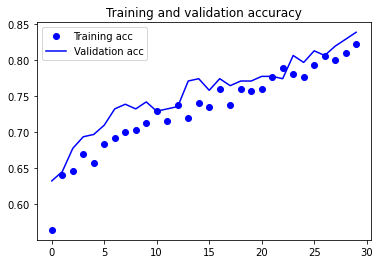

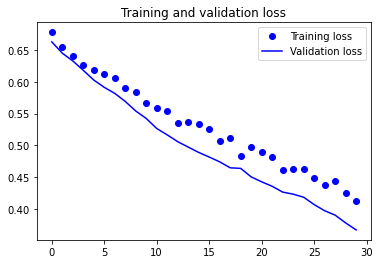

In [20]:
get_plot(history)

In [21]:
def regressor(feature_dim=2):
    model = Sequential()
    model.add(LSTM(units = 50, dropout=0.2, return_sequences = False, input_shape=train_X.shape[-feature_dim:]))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['acc'])
    
    return model

In [22]:
regressor = regressor(feature_dim=2)

history = regressor.fit(train_X, train_Y, epochs=30, batch_size=64, validation_data=(val_X, val_Y))

Train on 1239 samples, validate on 310 samples
Epoch 1/30
1239/1239 [==============================] - 0s 331us/step - loss: 0.6630 - acc: 0.0000e+00 - val_loss: 0.5638 - val_acc: 0.0000e+00
Epoch 2/30
1239/1239 [==============================] - 0s 65us/step - loss: 0.4989 - acc: 0.0000e+00 - val_loss: 0.5622 - val_acc: 0.0000e+00
Epoch 3/30
1239/1239 [==============================] - 0s 59us/step - loss: 0.4864 - acc: 0.0000e+00 - val_loss: 0.5663 - val_acc: 0.0000e+00
Epoch 4/30
1239/1239 [==============================] - 0s 63us/step - loss: 0.4897 - acc: 0.0000e+00 - val_loss: 0.5630 - val_acc: 0.0000e+00
Epoch 5/30
1239/1239 [==============================] - 0s 67us/step - loss: 0.4769 - acc: 0.0000e+00 - val_loss: 0.5638 - val_acc: 0.0000e+00
Epoch 6/30
1239/1239 [==============================] - 0s 64us/step - loss: 0.4800 - acc: 0.0000e+00 - val_loss: 0.5627 - val_acc: 0.0000e+00
Epoch 7/30
1239/1239 [==============================] - 0s 61us/step - loss: 0.4768 - acc: 0.0

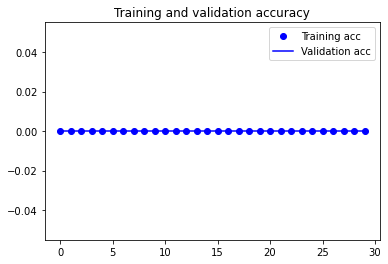

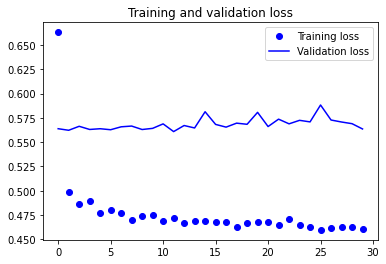

In [23]:
get_plot(history)

## Task 4:  Advanced recurrent model to beat the baseline

Hope you have obtained a good model which can beat the baseline obtained by the naive method. Unfortunately, very likely, you may have found that a simple LSTM model cannot beat the naive baseline. 

Now try to create a more advanced model which can achieve better performance. A few options for you to consider:

- Select only useful features manually or use CNN (as the reference paper did)
- Use bidirectional RNN
- Go deeper by stacking RNN or dense layers
- Feature engineering with your knowledge in Financial Engineering
- Be creative as you can!

You can use include any mechanism you like into the model. The only requirement for this task is to have LSTM/GRU layers in your model.


`Your target is to create a model which can outputform those two in Task 3. If you can beat the naive baseline, you'll get bonus credits!`

In [24]:
# Classifier 2

model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=False), input_shape=train_X.shape[-2:]))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
history = model.fit(train_X, train_Y_bi, epochs=30, batch_size=64, validation_data=(val_X, val_Y_bi))

Train on 1239 samples, validate on 310 samples
Epoch 1/30
1239/1239 [==============================] - 1s 525us/step - loss: 0.6826 - acc: 0.5504 - val_loss: 0.6827 - val_acc: 0.5677
Epoch 2/30
1239/1239 [==============================] - 0s 68us/step - loss: 0.6639 - acc: 0.6126 - val_loss: 0.6684 - val_acc: 0.6065
Epoch 3/30
1239/1239 [==============================] - 0s 62us/step - loss: 0.6529 - acc: 0.6384 - val_loss: 0.6569 - val_acc: 0.6065
Epoch 4/30
1239/1239 [==============================] - 0s 61us/step - loss: 0.6440 - acc: 0.6497 - val_loss: 0.6495 - val_acc: 0.6290
Epoch 5/30
1239/1239 [==============================] - 0s 63us/step - loss: 0.6363 - acc: 0.6618 - val_loss: 0.6427 - val_acc: 0.6645
Epoch 6/30
1239/1239 [==============================] - 0s 62us/step - loss: 0.6290 - acc: 0.6651 - val_loss: 0.6345 - val_acc: 0.6613
Epoch 7/30
1239/1239 [==============================] - 0s 62us/step - loss: 0.6220 - acc: 0.6764 - val_loss: 0.6275 - val_acc: 0.6806
Epoch 8

In [25]:
model.evaluate(test_X, test_Y_bi)

386/386 [==============================] - 0s 57us/step


[0.5266260229861798, 0.7538859844207764]

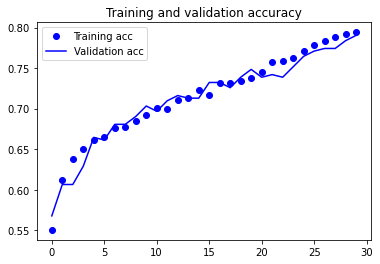

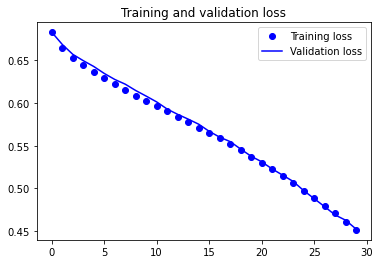

In [26]:
get_plot(history)

In [27]:
# regressor 2

model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=False), input_shape=train_X.shape[-2:]))
model.add(Dense(1, activation='relu'))
    
model.compile(optimizer='rmsprop', loss='mse', metrics=['acc'])

history = model.fit(train_X, train_Y, epochs=30, batch_size=64, validation_data=(val_X, val_Y))

Train on 1239 samples, validate on 310 samples
Epoch 1/30
1239/1239 [==============================] - 1s 514us/step - loss: 0.6178 - acc: 0.0000e+00 - val_loss: 0.6059 - val_acc: 0.0000e+00
Epoch 2/30
1239/1239 [==============================] - 0s 61us/step - loss: 0.4928 - acc: 0.0000e+00 - val_loss: 0.5756 - val_acc: 0.0000e+00
Epoch 3/30
1239/1239 [==============================] - 0s 67us/step - loss: 0.4732 - acc: 0.0000e+00 - val_loss: 0.5693 - val_acc: 0.0000e+00
Epoch 4/30
1239/1239 [==============================] - 0s 69us/step - loss: 0.4667 - acc: 0.0000e+00 - val_loss: 0.5661 - val_acc: 0.0000e+00
Epoch 5/30
1239/1239 [==============================] - 0s 67us/step - loss: 0.4627 - acc: 0.0000e+00 - val_loss: 0.5639 - val_acc: 0.0000e+00
Epoch 6/30
1239/1239 [==============================] - 0s 67us/step - loss: 0.4608 - acc: 0.0000e+00 - val_loss: 0.5628 - val_acc: 0.0000e+00
Epoch 7/30
1239/1239 [==============================] - 0s 64us/step - loss: 0.4597 - acc: 0.0

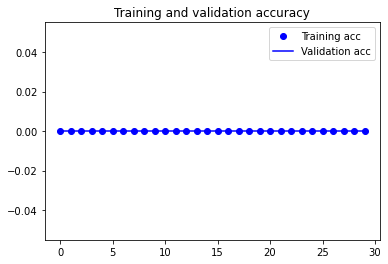

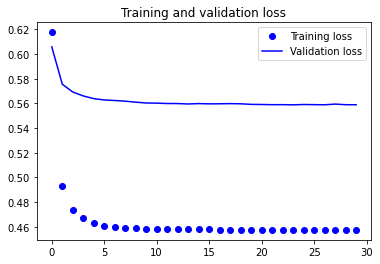

In [28]:
get_plot(history)

## Task 5: Analysis

Hope you have achieved your goal!

Now write a short analysis to discuss what you have learned from this assignment:
- What have worked and what didn't work as expected?
- How did you choose hyperparaters?
- How did you tune the models?


Good luck!

Accuracy from (bidirectional) RNN classifier with LSTM can reach 0.8, higher than biseline. 